In [36]:
import numpy as np
import numpy.ma as ma
import pandas as pd 
import rasterio
from osgeo.gdalconst import *
from numpy import *
import matplotlib as mpl
from osgeo import gdal
from gdalconst import *
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gds
from mpl_toolkits.axes_grid1 import make_axes_locatable

import geopandas as gpd 

import lightgbm as lgbm
from sklearn.externals import joblib
#from skimage import exposure
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cross_decomposition import CCA
from scipy.stats import stats
from scipy.spatial import distance
from numpy.linalg import eigh, eig, inv

from sklearn import mixture

from multiprocessing import Pool
from shapely.geometry import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.linalg import eigh, eig, inv
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# Misc
import seaborn as sns
import argparse
import rasterio
import shutil
import numpy
import math
import glob
import sys
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

### Preparation of Sentinel 2 Images

In [2]:
path = r'C:\Users\EnviSAGEPC\Desktop\Hidden Markov\Mosaic\LightGBM'
path_1 = r'C:\Users\EnviSAGEPC\Desktop\Hidden Markov\Land Cover Probabilities\2016' #Land Cover Probability 2016
path_2 = r'C:\Users\EnviSAGEPC\Desktop\Hidden Markov\Land Cover Probabilities\2017' #Land Cover Probability 2017
path_3 = r'C:\Users\EnviSAGEPC\Desktop\Hidden Markov\Land Cover Probabilities\2018' #Land Cover Probability 2018

In [3]:
def _READ_(folder):
    
    array = {}
    
    for root, dirs, files in os.walk (folder):
        for name in files:
            if name.endswith((".tif")) and not name.startswith(('.')):
                #print ('Land cover file:', name)
                date = name.split('_', 4)[2]
                p = date.split('.',4)[0]
                image = root+"/"+name
                band = _band_indices_(image)
                array[p] = (band)
                del band
                            
    return array

In [4]:
def _band_indices_(file):
    
    file = gdal.Open(file, gdal.GA_ReadOnly)
    
    gtr = file.GetGeoTransform()
    dvr = file.GetDriver()
    col = file.RasterXSize
    row = file.RasterYSize
    bnd = file.RasterCount
    prj = file.GetProjection()
    
    array = []
    
    for b in range(bnd+1)[1::]:
        band = file.GetRasterBand(b)
        arry = band.ReadAsArray().astype(np.float64)
        array.append(arry)
        del band, arry
    
    band = np.dstack(b for b in array)
    
    return band

In [31]:
%%time
dataset = _READ_(path)
land_cover_2016 = _READ_(path_1)
land_cover_2017 = _READ_(path_2)
land_cover_2018 = _READ_(path_3)
print ('Number of Land cover Maps:', len(dataset))
for date in dataset.keys():
    print ('Land cover dates : {i}'.format(i=date))

C:\Users\EnviSAGEPC\Anaconda3\envs\lib\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Number of Land cover Maps: 3
Land cover dates : 2016
Land cover dates : 2017
Land cover dates : 2018
Wall time: 13.1 s


In [37]:
%%time
markov = []
for date in dataset.keys():
    array = np.array(dataset[date])
    n, m, b = array.shape
    array = np.moveaxis(array, 2, 0)
    img = cv2.medianBlur(array[0].astype(np.uint8),3)
    #print (img.shape)
    markov.append(img.reshape(n*m*b))
    del array, img

c = np.unique(markov)
t = len(dataset)-1

mat = np.array(np.array(markov)) #dataset for Markov Transition Probability Matrix

Wall time: 1.41 s


In [33]:
mat = mat.T
mat.shape

(17540110, 3)

In [39]:
new_mat = np.stack((mat[1], mat[2])).T
new_mat.shape

(17540110, 2)

### Markov Transition Probability Matrix

In [40]:
import giddy

#Transition Probability Matrix
m = giddy.markov.Markov(mat)
transition = np.delete(m.p, (0), axis=0)
transition = np.delete(transition, (0), axis=1)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 503: character maps to <undefined>

In [19]:
#Transition Probability Matrix
transition

#Logical Filter based on van Elburg (2017) 
Logical_filter = np.array([[1,1,1,0,1,0,0],
            [0,1,1,0,0,0,0],
            [1,1,1,0,1,0,0],
            [1,1,1,1,1,0,0],
            [1,1,1,0,1,1,0],
            [1,1,1,0,1,1,0],
            [0,0,1,0,0,0,1]])

NameError: name 'transition' is not defined

In [10]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from scipy.stats import multivariate_normal

scaler = MinMaxScaler(feature_range=(0,1))

markov_filter = transition
i = 0
for row in markov_filter:
    #x = row.shape
    #row = row.reshape(1,x[0])
    #c =  1.0/(np.sum(row[row != 0]))
    #row = row*c
    markov_filter[i] = row
    i += 1

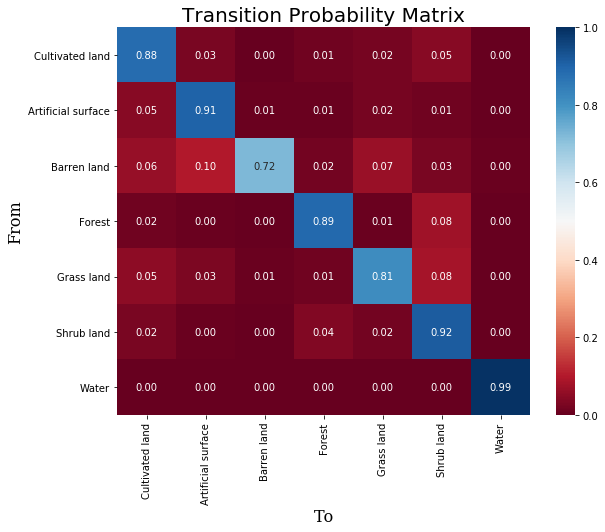

In [11]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

label = ['Cultivated land', 'Artificial surface', 'Barren land', 'Forest', 'Grass land', 'Shrub land', 'Water']

plt.figure(figsize=(9,7.5))
sns.heatmap(markov_filter, cmap='RdBu', annot=True, xticklabels=label, yticklabels=label, fmt='.2f',
           vmin=0, vmax=1)
plt.xlabel('To', fontdict=font)
plt.ylabel('From', fontdict=font)
plt.title('Transition Probability Matrix', fontsize=20)
plt.tight_layout()
plt.show()

### Data Preparation

In [56]:
col, row, band = land_cover_2016['2016'].shape
col, row, band = land_cover_2017['2017'].shape
col, row, band = land_cover_2018['2018'].shape
LC2016 = np.array(pd.DataFrame(land_cover_2016['2016'].reshape(col*row, band)))
LC2017 = np.array(pd.DataFrame(land_cover_2017['2017'].reshape(col*row, band)))
LC2018 = np.array(pd.DataFrame(land_cover_2018['2018'].reshape(col*row, band)))

In [57]:
print (LC2016.shape, LC2017.shape, LC2018.shape)

(17724015, 7) (17724015, 7) (17724015, 7)


In [58]:
Mat2016 = LC2016.copy()
Mat2017 = LC2017.copy()
Mat2018 = LC2018.copy()

### Determining Change/Unchange Pixels using Multivariate Alteration Detection - CCA

In [59]:
#Compute for Canonical Component for detection of change/unchange pixels 
x = Mat2018.T 
y = Mat2016.T

i = 0
for row in x:
    x[i] = row - np.mean(row)
    i+=1

i=0
for row in y:
    y[i] = row - np.mean(row)
    i += 0

#compute for the variance and the covariance
xx = np.matmul(x, np.transpose(x))
xx_inv = inv(xx)
yy = np.matmul(y, np.transpose(y))
yy_inv = inv(yy)
xy = np.matmul(x, np.transpose(y))
yx = np.matmul(y, np.transpose(x))

#prepare for matrices for eigenvalue decomposition
matrix_1 = np.matmul(xx_inv, xy)
matrix_1 = np.matmul(matrix_1, yy_inv)
matrix_1 = np.matmul(matrix_1, yx)

matrix_2 = np.matmul(yy_inv, yx)
matrix_2 = np.matmul(matrix_2, xx_inv)
matrix_2 = np.matmul(matrix_2, xy)

#eigenvalue decomposition
w_x, v_x = eig(matrix_1)
w_y, v_y = eig(matrix_2)

#sort the coeff vectors from lowest to highest correlation
v_x = v_x[w_x.argsort()]
v_y = v_y[w_y.argsort()]

#compute for all MAD
mad = np.zeros(x.shape)

i = 0
for vector in v_x:
    u = np.matmul(np.transpose(vector.reshape(7,1)), x)
    v = np.matmul(np.transpose(v_y[i].reshape(7,1)), y)
    mad[i] = u - v
    i += 1
    
#normalize MAD
nml_mad = np.zeros(x.shape)

i = 0
for vector in mad:
    nml_mad[i] = np.square(vector / np.std(vector))
    i += 1

nml_mad
#summation per column for chi-square distribution
chi = np.sum(nml_mad, axis=0)
chi = pd.DataFrame(chi)

In [15]:
from sklearn.cross_decomposition import CCA

x = Mat2018
y = Mat2017

cca = CCA(n_components=7)
cca.fit(x,y)
X_c, Y_c = cca.transform(x, y)
print (X_c.shape,Y_c.shape)

(17724015, 7) (17724015, 7)


In [16]:
mad = np.zeros(x.T.shape)

i = 0
for vector in X_c.T:
    u = vector
    v = Y_c.T[i]
    mad[i] = u - v
    i += 1

#normalize MAD
nml_mad = np.zeros(x.T.shape)

i = 0
for vector in mad:
    nml_mad[i] = np.square(vector / np.std(vector))
    i += 1

nml_mad
#summation per column for chi-square distribution
chi = np.sum(nml_mad, axis=0)
chi = pd.DataFrame(chi)

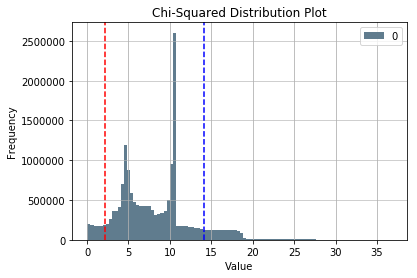

In [80]:
# Pixel Stability using Canonical Component Analysis - Multivariate Alteration Detection 
size, scale = 1000, 10

chi.plot.hist(grid=True, bins=100, rwidth=1.5, color='#607c8e')

plt.axvline(2.167, color='red', ls='--')
plt.axvline(14.07, color='blue', ls='--')
plt.title('Chi-Squared Distribution Plot')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.savefig('Chi-Squared Distribution Plot')

In [61]:
del nml_mad, mad, v_x, v_y, matrix_1, matrix_2, xx, xx_inv, yy, yy_inv, xy, yx, x, y

### Thresholding of Pixels using Chi Square Table

In [62]:
cond1 = np.array(chi < 14.07)
cond2 = np.array(chi > 2.167)

c1 = np.array(chi > 14.07)
c2 = np.array(chi < 2.167)
pif = np.logical_or(c1, c2)

#Mean of Chi-Square Distribution = 7.0
pifs = np.dstack(([pif,pif,pif,pif,pif,pif,pif]))
cond1_pif = np.dstack(([c1, c1, c1, c1, c1, c1, c1]))
cond2_pif = np.dstack(([c2, c2, c2, c2, c2, c2, c2]))
n, m, b = pifs.shape
pifs = pifs.reshape(n, m*b)
cond1_pif = cond1_pif.reshape(n, m*b)
cond2_pif = cond2_pif.reshape(n, m*b)
print (pifs.shape, cond1_pif.shape, cond2_pif.shape)

(17724015, 7) (17724015, 7) (17724015, 7)


In [63]:
condition1_boolean, condition1_value = np.unique(cond1, return_counts=True)
condition2_boolean, condition2_value = np.unique(cond2, return_counts=True)
condition3_boolean, condition3_value = np.unique(pif, return_counts=True)

print ("Unchange Pixels: Condition #1")
print (condition1_boolean, condition1_value)
print ("--------------------------------")
print ("Change Pixels: Condition #2")
print (condition2_boolean, condition2_value)
print ("--------------------------------")
print ("Uncertain Pixels: Condition #3")
print (condition3_boolean, condition3_value)

Unchange Pixels: Condition #1
[False  True] [ 1826622 15897393]
--------------------------------
Change Pixels: Condition #2
[False  True] [ 1042817 16681198]
--------------------------------
Uncertain Pixels: Condition #3
[False  True] [14854576  2869439]


In [39]:
img = r'C:\Users\EnviSAGEPC\Desktop\Hidden Markov\Land Cover Probabilities\2016\LagunaLakeWatershed_LandCover_2016.tif'

ras = gdal.Open(img, gdal.GA_ReadOnly)
gtr = ras.GetGeoTransform()
dvr = ras.GetDriver()
col = ras.RasterXSize
row = ras.RasterYSize
bnd = ras.RasterCount
prj = ras.GetProjection()

In [40]:
import enum
class LULC(enum.Enum):
    UNCHANGE_Pixels      = (0,  'Change','Orange')
    CHANGE_Pixels        = (1,  'NoChange','Black')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3 

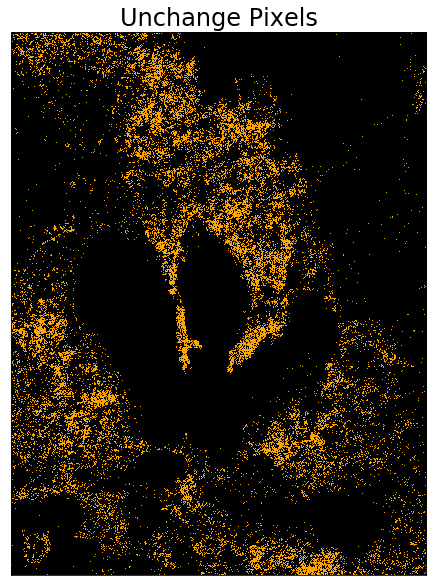

In [41]:
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
plt.figure(figsize=(20,10))
plt.imshow(cond1.reshape(row,col), cmap=lulc_cmap)
plt.xticks([])
plt.yticks([])
plt.title('Unchange Pixels', fontsize=24)
plt.show()

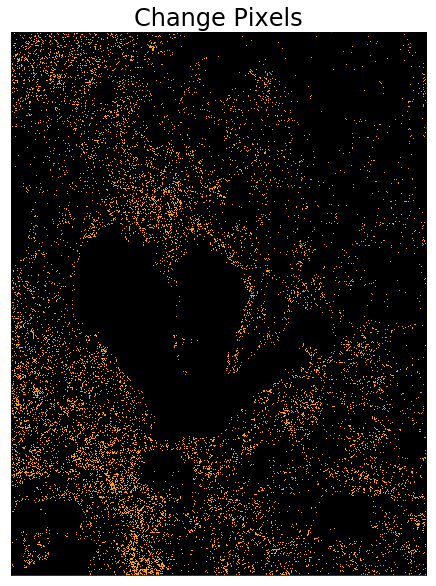

In [42]:
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
plt.figure(figsize=(20,10))
plt.imshow(cond2.reshape(row,col), cmap=lulc_cmap)
plt.xticks([])
plt.yticks([])
plt.title('Change Pixels', fontsize=24)
plt.show()

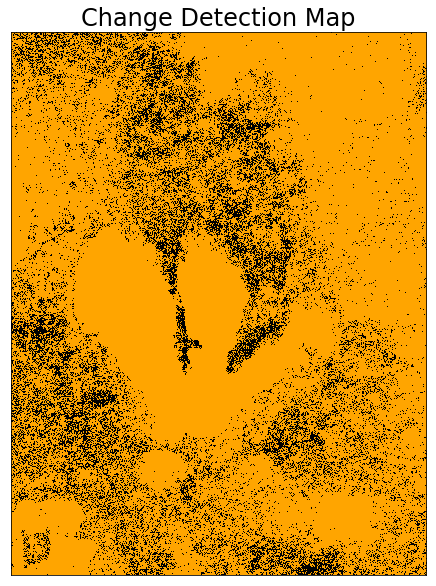

In [43]:
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
plt.figure(figsize=(20,10))
plt.imshow(pif.reshape(row,col), cmap=lulc_cmap)
plt.xticks([])
plt.yticks([])
plt.title('Change Detection Map', fontsize=24)
plt.show()

In [46]:
%%time
#T = pd.DataFrame(markov_filter)

# Condition No. One (Chi < 2.067)
M = pd.DataFrame(ma.masked_array(LC2018, cond1_pif))
M = M.dropna(axis=0, how='all')
M = M.reindex([i for i in range(LC2018.shape[0])])
M[M.isnull()] = LC2018
print (M)

                 0         1         2             3         4             5  \
0         0.000039  0.974131  0.025576  4.535106e-07  0.000248  5.974863e-07   
1         0.001733  0.937377  0.058344  1.157678e-05  0.002501  8.925374e-06   
2         0.003501  0.985082  0.009038  8.950368e-06  0.002343  1.197121e-05   
3         0.012045  0.937067  0.041316  3.789411e-05  0.009408  5.733130e-05   
4         0.090739  0.033997  0.443345  4.653452e-04  0.419103  1.217338e-02   
5         0.026588  0.000136  0.012676  6.876946e-05  0.880409  8.011510e-02   
6         0.083340  0.000136  0.023570  1.774183e-04  0.552131  3.406280e-01   
7         0.121862  0.000662  0.577341  2.907855e-04  0.295802  4.025158e-03   
8         0.334199  0.000419  0.001335  2.544546e-04  0.663135  4.496293e-04   
9         0.776360  0.000066  0.000120  5.543521e-05  0.223021  1.490634e-04   
10        0.968783  0.000271  0.000214  4.725749e-05  0.029802  1.316596e-04   
11        0.877988  0.000022  0.000010  

In [47]:
# Condition No. two (Chi > 14.067)
M = pd.DataFrame(ma.masked_array(M, cond2_pif))
M = M.dropna(axis=0, how='all')
M = M.reindex([i for i in range(Mat2017.shape[0])])
M[M.isnull()] = LC2016
print (M)

                 0         1         2             3         4             5  \
0         0.000039  0.974131  0.025576  4.535106e-07  0.000248  5.974863e-07   
1         0.001733  0.937377  0.058344  1.157678e-05  0.002501  8.925374e-06   
2         0.003501  0.985082  0.009038  8.950368e-06  0.002343  1.197121e-05   
3         0.012045  0.937067  0.041316  3.789411e-05  0.009408  5.733130e-05   
4         0.090739  0.033997  0.443345  4.653452e-04  0.419103  1.217338e-02   
5         0.026588  0.000136  0.012676  6.876946e-05  0.880409  8.011510e-02   
6         0.083340  0.000136  0.023570  1.774183e-04  0.552131  3.406280e-01   
7         0.978730  0.000905  0.000162  2.286313e-04  0.009517  1.045658e-02   
8         0.334199  0.000419  0.001335  2.544546e-04  0.663135  4.496293e-04   
9         0.776360  0.000066  0.000120  5.543521e-05  0.223021  1.490634e-04   
10        0.968783  0.000271  0.000214  4.725749e-05  0.029802  1.316596e-04   
11        0.877988  0.000022  0.000010  

In [48]:
Mat3 = pd.DataFrame(ma.masked_array(M, pifs))
Mat3 = Mat3.dropna(axis=0, how='all')
Mat3 = pd.DataFrame(np.matmul(Mat3,markov_filter))
Mat3 = Mat3.reindex([i for i in range(Mat2018.shape[0])])
Mat3[Mat3.isnull()] = M
print (Mat3)

                 0         1         2         3         4         5         6
0         0.123028  0.793047  0.018578  0.027548  0.024332  0.011137  0.002329
1         0.128510  0.772439  0.028456  0.028254  0.027616  0.012259  0.002467
2         0.123340  0.797593  0.013552  0.027429  0.024232  0.011560  0.002295
3         0.133589  0.768192  0.023218  0.028492  0.029823  0.014195  0.002492
4         0.298393  0.167985  0.142973  0.049742  0.230575  0.106738  0.003594
5         0.026588  0.000136  0.012676  0.000069  0.880409  0.080115  0.000007
6         0.243278  0.032601  0.012448  0.085446  0.261117  0.363936  0.001174
7         0.978730  0.000905  0.000162  0.000229  0.009517  0.010457  0.000001
8         0.427887  0.038906  0.007204  0.054539  0.313045  0.155516  0.002902
9         0.613700  0.035373  0.004457  0.059666  0.155169  0.125494  0.006142
10        0.694290  0.034227  0.003445  0.061916  0.085802  0.112263  0.008057
11        0.656422  0.034633  0.003877  0.060877  0.

In [49]:
del LC2016, LC2017, LC2018

In [50]:
Mat2016_markov = np.array(Mat3.T)
Mat2016_markov.shape

(7, 17724015)

In [51]:
markov = np.zeros(chi.shape)
i = 0
for row in np.array(Mat3):
    markov[i] = np.int(np.argmax(row) + 1)
    i += 1
markov.shape

(17724015, 1)

In [52]:
img = r'C:\Users\EnviSAGEPC\Desktop\Hidden Markov\Land Cover Probabilities\2016\LagunaLakeWatershed_LandCover_2016.tif'

ras = gdal.Open(img, gdal.GA_ReadOnly)
gtr = ras.GetGeoTransform()
dvr = ras.GetDriver()
col = ras.RasterXSize
row = ras.RasterYSize
bnd = ras.RasterCount
prj = ras.GetProjection()

In [53]:
tiff = markov.reshape(row,col)
tiff.shape

(4815, 3681)

In [54]:
outputPath = os.getcwd()
columns2Ras = 'Markov'
#dfAsArr = np.array(predict).astype(int)
#fAsArr = dfAsArr.reshape(nCols,nRows).T
ns = dvr.Create(os.path.join(outputPath,'%s_LandCover_2016_2.tif'%(columns2Ras)),\
                      col,row,1,GDT_Float32)
ns.SetGeoTransform(gtr) 
ns.SetProjection(prj)
outputRas = ns.GetRasterBand(1)
outputRas.WriteArray(tiff,0,0)
ns.FlushCache()
outputRas.FlushCache()
del outputRas,ns,tiff

In [44]:
i = 0
for raster in Mat2017_markov:
    print (raster)
    tiff = raster.reshape(row,col)
    outputPath = os.getcwd()
    columns2Ras = 'Markov_' + str(i+1)
    #dfAsArr = np.array(predict).astype(int)
    #fAsArr = dfAsArr.reshape(nCols,nRows).T
    ns = dvr.Create(os.path.join(outputPath,'%s_LandCover_2017.tif'%(columns2Ras)),\
                      col,row,1,GDT_Float32)
    ns.SetGeoTransform(gtr) 
    ns.SetProjection(prj)
    outputRas = ns.GetRasterBand(1)
    outputRas.WriteArray(tiff,0,0)
    ns.FlushCache()
    outputRas.FlushCache()
    del outputRas,ns,tiff
    i += 1

[0.09862257 0.10260738 0.09983086 ... 0.82927954 0.76720345 0.54875255]
[8.14291820e-01 7.92948842e-01 8.18991305e-01 ... 1.78139016e-04
 6.25149929e-04 8.67283554e-04]
[0.025598   0.03611498 0.02023009 ... 0.00094127 0.00168486 0.0005893 ]
[0.01257903 0.01294989 0.0125785  ... 0.00012782 0.00087219 0.00263398]
[0.03784577 0.0432704  0.03700962 ... 0.16059515 0.14839853 0.21796697]
[0.00940193 0.01027307 0.0097413  ... 0.00887614 0.08121112 0.22918439]
[1.66087185e-03 1.83541926e-03 1.61833572e-03 ... 1.91623985e-06
 4.71075555e-06 5.51550283e-06]
